In [12]:
####################
# EDIT THE VARIABLE VALUES IN THIS CELL
####################

# Name of data file
filename = 'data.csv'

# Modulating frequency in Hz
frequency = 70

# Number of cycles over which to take average
number_of_cycles = 20

# Save the graph which is produced as a file? (True or False)
save_fig = False

In [2]:
##########################
# YOU DO NOT NEED TO EDIT ANYTHING IN THIS CELL
# YOU WILL ONLY NEED TO RUN THIS CELL ONCE WHEN YOU FIRST OPEN THE NOTEBOOK
##########################

### Import Necessary Modules
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd


### Significant figures rounding
def sigfig(x, n):
    # Rounds number x to n significant figures
    if type(n) != int:
        print('Error: non-integer significant figures')
    else:
        sf1 = math.ceil(-np.log10(abs(x)))     #finds first sig fig
        y = round(x, sf1+n-1)
        return y
    
    
### Moving average function
# Takes a number (window_length) of values in each average to return an array

def moving_average(data_array, window_length):
    
    moving_average_array = []      # Initialize an empty list to store moving averages
    
    i = 0
    while i < len(data_array) - window_length + 1:

        # Calculate the average of current window
        window_average = np.sum(data_array[i:i+window_length]) / window_length

        # Store the average of current window in moving average list
        moving_average_array.append(window_average)

        # Shift window to right by one position
        i += 1
    return moving_average_array


### Dictionary of units of time from PicoScope data
units = {'(s)':1, '(ms)':10**-3, '(us)':10**-6, '(ns)':10**-9}


### Converts tuple to string
def convertTuple(tup):
    # initialize an empty string
    string = ''
    for item in tup:
        string = string + item
    return string

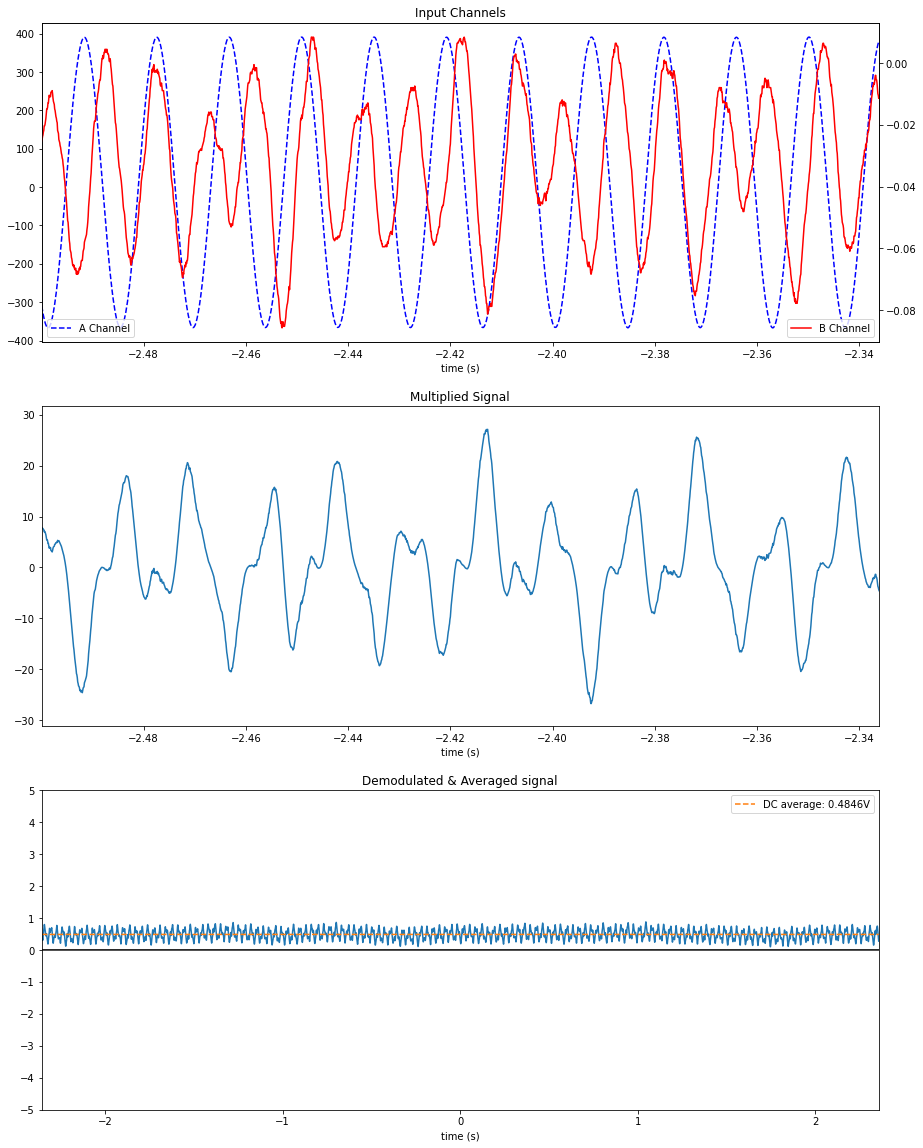

In [ ]:
###################
# YOU SHOULD ALSO NOT NEED TO EDIT ANYTHING IN THIS CELL
###################

## Find out the units of the 'time' column
pddat = pd.read_csv(filename, header = [0,1])

time_head = list(pddat.columns)[0]
text = convertTuple(time_head)    # Turns time_head into a string
tbase = text.replace('Time', '')    # and gets rid of 'Time'


## Import the data
data = np.genfromtxt(filename, delimiter = ',', skip_header = 2)

# Plot a small range of the scope channels A & B
npo = 2000
if npo < len(data):
    tlim = npo
else:
    tlim = len(data)

ABtime = data[0:tlim, 0]
A = data[0:tlim, 1]
B = data[0:tlim, 2]

ABTmin = ABtime[0]
ABTmax = ABtime[tlim-1]


## Create necessary arrays and parameters
    # (time, modulating signal, modulated signal)
time = data[:, 0]
mod = data[:, 1]
sig = data[:, 2]

# Limits for x-axis of time plot
Tmin = time[0]
Tmax = time[len(time)-1]


# Time spacing between samples (taken as average of 100 samples)
total = 0
L = 1000
for i in range(int(round(len(time), 0)/2-L/2), int(round(len(time), 0)/2+L/2)):
    diff = time[i+1] - time[i]
    total += diff
samplespace = sigfig(total/L, 10)


## Multiply signals together
demod = np.multiply(mod, sig)


## Average the signal over N cycles
T = 1/frequency * units[tbase]    # Period of modulating signal in the units of the PicoScope output
if (Tmax-Tmin) > (number_of_cycles*T):    # Check there are enough cycles in the time range
    N = number_of_cycles
else:
    N = math.ceil((Tmax-Tmin)/T-1)
    print(f'Trying to average over too many cycles!\nAveraging over all {N} cycles instead.')
Tavg = N*T        # Averaging period
avg_window = int(round(Tavg/samplespace, 0))        # Number of data points in averaging period

DC_avg = moving_average(demod, avg_window)    # Taking moving average

# Cut values off both ends of the time array to give it the same length as DC_avg
avgtime = time[int(round((len(time)-len(DC_avg))/2, 0)) : int(round((len(time)+len(DC_avg))/2, 0))]
avgTmin = min(avgtime)
avgTmax = max(avgtime)
# Set the y-limits for the demodulation plot
avgymax = 2* max((max(DC_avg), abs(min(DC_avg))))

# DC average value over whole demodulated array
DC_avg_val = np.ones((np.size(avgtime))) * np.average(DC_avg)


## Plot
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize = (15, 20))

fig.set_facecolor('white')

ax0.plot(ABtime, A,'b--' , label = 'A Channel')
ax0.set_xlim(ABTmin,ABTmax)
ax01 = ax0.twinx()
ax01.plot(ABtime, B,'r-' , label = 'B Channel')
ax0.legend(loc = 'lower left')
ax01.legend(loc = 'lower right')
ax0.set_title('Input Channels')

ax1.set_title('Multiplied Signal')
ax1.plot(time, demod,'-')
ax1.set_xlim(ABTmin,ABTmax)

ax2.set_title('Demodulated & Averaged signal')
ax2.plot(avgtime, DC_avg,'-')
ax2.plot(avgtime, DC_avg_val, '--', label = f'DC average: {sigfig(DC_avg_val[0], 4)}V')
ax2.plot(avgtime, np.zeros(len(avgtime)), 'k')
ax2.set_xlim(avgTmin,avgTmax)
ax2.set_ylim(-avgymax, avgymax)
ax2.set_yticks(np.arange(-5, 6, 1))
ax2.legend()

for ax in (ax0, ax1, ax2):
    ax.set_xlabel(f'time {tbase}')
    
if save_fig == True:
    figname = input('Name to save figure as: ')
    fig.savefig(figname, facecolor = 'white')
plt.show()